# CIR Variance + Heston Equity Model — Simulation & Pricing Toolkit

This notebook provides a compact implementation of the classic **Heston-type dynamics** by applying the **Quadratic Exponential Scheme** for the simulation of the CIR-type dynamics of the Variance process.
Under the risk-neutral measure $\mathbb{Q}$, the Heston model dinamics are:

\begin{aligned}
dS_t &= r S_t\, dt + \sqrt{v_t}\, S_t\, dW_t^{(S)}, \\
dv_t &= \kappa(\bar v - v_t)\, dt + \gamma \sqrt{v_t}\, dW_t^{(v)}, \\
dW_t^{(S)}\, dW_t^{(v)} &= \rho\, dt.
\end{aligned}
The CIR part has the following conditional distribution for $s<t$:
$$v_t |v_s = \bar{c}(t,s) \chi^2 (\delta, \bar{\kappa}(t,s))$$
with:
\begin{aligned}
\bar{c}(t,s) &= \frac{\gamma^2}{4\kappa}\left(1-e^{-\kappa (t-s)} \right)\\
\delta &= \frac{4\kappa \bar{v}}{\gamma^2}\\
\bar{\kappa}(t,s) &= \frac{4\kappa e^{-\kappa (t-s)}}{\delta^2 (1-e^{-\kappa (t-s)})} v_s
\end{aligned}

The goal is to simulate variance/price paths and price common derivatives using:

- **Monte Carlo simulation** (with optional variance reduction via **control variates**)
- **COS method** (Fourier-cosine expansion) for fast European option pricing
- Additional analytics such as **density reconstruction**, **Greeks (Δ, Γ, Vega)**, and **variance swap fair strike**

The core logic is wrapped in a single class, `Cir`, which:
1. Simulates the **variance process** (CIR-like)
2. Builds the **equity process** under a Heston-style discretization
3. Prices payoffs (European calls/puts, down-and-out call) and diagnostics (variance swap, distribution plots)

For insight into the procedure, please refer to:

-Oosterlee, Cornelis W., and Lech A. Grzelak. Mathematical modeling and computation in finance: with exercises and Python and MATLAB computer codes. World Scientific, 2019. In particular, chapter 8 for basics on Heston-type dynamics, chapter 9 for simulation technique and the implementation of the quadratic exponential scheme and chapter 6 for the theory of the cos method.

In [27]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pandas as pd
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['figure.autolayout'] = True

In [23]:
class Cir:
    def __init__(self, gamma, k, v_bar, v0, S0, rho, r = 0, ndays: int = 365, nsim: int = 1):
        self.gamma = gamma
        self.k = k
        self.v_bar = v_bar
        self.v0 = v0
        self.S0 = S0
        self.rho = rho
        self.r = r
        self.alpha_star = 1.5
        self.time_scale = 365
        self.ndays = ndays #number of days until maturity
        self.nsim = nsim #number of paths to simulate if Monte Carlo method is used
        self.serie = np.array([])
        self.serie_heston = np.array([])

    def simulation(self):
        """ This function simulate the paths for the Variance Part given the input of the class"""
        t = np.linspace(start=0, stop=self.ndays / self.time_scale, num=self.ndays + 1)
        serie = np.zeros(shape=(self.nsim, t.shape[0]))
        serie[:, 0] = self.v0

        for i in range(len(t) - 1):
            check = self.ssq_bar(t[i + 1], t[i], serie[:, i]) / self.m_bar(t[i + 1], t[i], serie[:, i]) ** 2
            controllo = check < self.alpha_star
            u = np.random.uniform(0, 1, size=(self.nsim, 1))
            v = self.Finv_v2(u, self.c(self.m_bar(t[i + 1], t[i], serie[:, i]),
                                       self.ssq_bar(t[i + 1], t[i], serie[:, i])),
                             self.d(self.m_bar(t[i + 1], t[i], serie[:, i]),
                                    self.ssq_bar(t[i + 1], t[i], serie[:, i])))
            serie[:, i + 1] = v

            serie[controllo, i + 1] = self.a(m=self.m_bar(t[i + 1], t[i], serie[controllo, i]),bsq=self.bsq(self.m_bar(t[i + 1], t[i], serie[controllo, i]),self.ssq_bar(t[i + 1], t[i], serie[controllo, i]))) * (np.sqrt(self.bsq(self.m_bar(t[i + 1], t[i], serie[controllo, i]),self.ssq_bar(t[i + 1], t[i], serie[controllo, i]))) + np.random.normal(0, 1, size=len(controllo))) ** 2


            self.serie = serie
    def simulation_heston(self):
        self.simulation()
        t = np.linspace(start=0, stop=self.ndays / self.time_scale, num=self.ndays + 1)
        serie_hest = np.zeros(shape=(self.nsim, t.shape[0]))
        serie_hest[:,0] = np.log(self.S0)

        for i in range(len(t)-1):
            xt = serie_hest[:,i] + self.k0(t[i+1], t[i]) + self.k1(t[i+1], t[i]) * self.serie[:,i] + self.k2()*self.serie[:,i+1] + np.sqrt(self.k3(t[i+1], t[i]) * self.serie[:,i]) * np.random.normal(0,1, size=self.nsim)
            serie_hest[:,i+1] = xt
        self.serie_heston = np.exp(serie_hest)

    def down_and_out(self, down_barrier, K, use_control_variable: bool = True):
        #Simulazione di una call down and out
        start = datetime.datetime.now()
        if self.serie_heston.any() == False:
            self.simulation_heston()
        down_and_out_payoff = np.zeros(shape=self.nsim)
        discount = np.exp(- self.r * self.ndays / self.time_scale)
        mask = np.min(self.serie_heston, axis=1) >= down_barrier
        down_and_out_payoff[mask] = (self.serie_heston[mask, -1] - K) * discount
        if use_control_variable == True:
            # Come Control Variable utilizzo il payoff di una Call ATM forward
            CV = np.maximum(self.serie_heston[:, -1] - self.S0 * np.exp(self.r * self.ndays / self.time_scale),
                            0) * discount

            cov = np.cov(down_and_out_payoff, CV, ddof=1)[0, 1]

            c_star = cov / np.var(CV)
            print(f"Varianza payof: {down_and_out_payoff.var()}")
            down_and_out_payoff = down_and_out_payoff - c_star * (CV - np.mean(CV))
            print(f"Varianza Control: {down_and_out_payoff.var()}")


        print(f"Il Prezzo di un'Opzione Down and Out che scade tra {self.ndays} giorni con strike: {K} e Barriera: {down_barrier} è di {down_and_out_payoff.mean()}")

        print(f"Tempo Impiegato in Secondi: {(datetime.datetime.now() - start).seconds}")
        return down_and_out_payoff.mean()
    def call_eu(self, K, cos_method: bool = True, use_control_variable: bool = True):
        """
        :param K: è uno scalare perchè sennò il montecarlo esplode. Aggiustare per poter inserire un vettore di strike invece che solo uno scalare.
        """
        if cos_method == True:
            a = np.log(
                self.S0 / K) - 5  # da correggere per selezionarli bene sti limiti dove si assume l'intervallo di simmetria nella approssimazione con la serie di fourier
            b = np.log(self.S0 / K) + 5
            X = np.log(self.S0 / K)
            k = np.arange(1001)
            component = self.phi_h(u=k * np.pi / (b - a), t=self.ndays / self.time_scale, s=0, xs=np.log(self.S0),
                                   vs=self.v0) * self.Uk(k=k, a=a, b=b, type="call") * np.exp(
                1j * k * np.pi / (b - a) * (X - a))  # da correggere per vettori di strike
            component[0] = component[0] * .5
            prezzo = K * np.exp(-self.r * (self.ndays / self.time_scale)) * np.real(np.sum(component))
            print(f"Prezzo Opzione Call EU con Cos Method:{prezzo}")
            return prezzo
        else:
            start = datetime.datetime.now()
            if self.serie_heston.any() == False:
                self.simulation_heston()
            discount = np.exp(- self.r * self.ndays / self.time_scale)

            call_payoff = np.maximum(self.serie_heston[:, -1] - K, 0) * discount

            if use_control_variable == True:
                # Come Control Variable utilizzo il payoff di una Call ATM forward
                CV = np.maximum(self.serie_heston[:, -1] - self.S0 * np.exp(self.r * self.ndays / self.time_scale),
                                0) * discount

                cov = np.cov(call_payoff, CV, ddof=1)[0, 1]

                c_star = cov / np.var(CV)
                print(f"Varianza payoff: {call_payoff.var()}")
                call_payoff = call_payoff - c_star * (CV - np.mean(CV))
                print(
                    f"Il Prezzo di un'Opzione Call EU che scade tra {self.ndays} giorni con strike: {K}  è di {call_payoff.mean()}")
                print(f"Varianza Control: {call_payoff.var()}")
            else:
                print(
                    f"Il Prezzo di un'Opzione Call EU che scade tra {self.ndays} giorni con strike: {K}  è di {call_payoff.mean()}")

            print(f"Tempo Impiegato in Secondi: {(datetime.datetime.now() - start).seconds}")
            return call_payoff.mean()
    def put_eu(self, K, cos_method: bool = True, use_control_variable: bool = True):
        """
        :param K: è uno scalare perchè sennò il montecarlo esplode. Aggiustare per poter inserire un vettore di strike invece che solo uno scalare.
        """
        if cos_method == True:
            a = np.log(
                self.S0 / K) - 5  # da correggere per selezionarli bene sti limiti dove si assume l'intervallo di simmetria nella approssimazione con la serie di fourier
            b = np.log(self.S0 / K) + 5
            X = np.log(self.S0 / K)
            k = np.arange(1001)
            component = self.phi_h(u=k * np.pi / (b - a), t=self.ndays / self.time_scale, s=0, xs=np.log(self.S0),
                                   vs=self.v0) * self.Uk(k=k, a=a, b=b, type="put") * np.exp(
                1j * k * np.pi / (b - a) * (X - a))  # da correggere per vettori di strike
            component[0] = component[0] * .5
            prezzo = K * np.exp(-self.r * (self.ndays / self.time_scale)) * np.real(np.sum(component))
            print(f"Prezzo Opzione Put EU con Cos Method: {prezzo}")
            return prezzo
        else:
            start = datetime.datetime.now()
            if self.serie_heston.any() == False:
                self.simulation_heston()
            discount = np.exp(- self.r * self.ndays / self.time_scale)

            put_payoff = np.maximum(K - self.serie_heston[:, -1], 0) * discount

            if use_control_variable == True:
                # Utilizzo come variabile di controllo una Put ATM forward
                CV = np.maximum(self.S0 * np.exp(self.r * self.ndays / self.time_scale) - self.serie_heston[:, -1],
                                0) * discount
                cov = np.cov(put_payoff, CV, ddof=1)[0, 1]

                c_star = cov / np.var(CV)
                print(f"Varianza payoff: {put_payoff.var()}")
                put_payoff = put_payoff - c_star * (CV - np.mean(CV))
                print(
                    f"Il Prezzo di un'Opzione Put EU che scade tra {self.ndays} giorni con strike: {K}  è di {put_payoff.mean()}")
                print(f"Varianza Control: {put_payoff.var()}")
            else:
                print(
                    f"Il Prezzo di un'Opzione Put EU che scade tra {self.ndays} giorni con strike: {K}  è di {put_payoff.mean()}")

            print(f"Tempo Impiegato in Secondi: {(datetime.datetime.now() - start).seconds}")
            return put_payoff.mean()
    def Variance_Swap_FS(self, use_control_variable = True):
        #Aggiungere metodo simile al Cos method.
        start = datetime.datetime.now()
        if self.serie_heston.any() == False:
            self.simulation_heston()
        Ks = (self.time_scale/self.ndays) * np.sum(np.power(np.log(self.serie_heston[:,1:] / self.serie_heston[:,:-1]),2), axis = 1)
        if use_control_variable == True:
            discount = np.exp(-self.r * self.ndays/self.time_scale)
            # Utilizzo come variabile di controllo il sottostante
            CV = self.serie_heston[:,-1] * discount
            cov = np.cov(Ks.reshape(-1), CV, ddof=1)[0, 1]
            c_star = cov / np.var(CV)
            print(f"Varianza payoff: {Ks.var()}")
            Ks = Ks - c_star * (CV - self.S0)
            print(
               f"Il Fair Strike Price di un Variance Swap che Scade tra {self.ndays} Giorni è K: {Ks.mean()}")
            print(f"Varianza Control: {Ks.var()}")
        else:
            print(
                f"Il Fair Strike Price di un Variance Swap che Scade tra {self.ndays} è K: {Ks.mean()}")
        print(f"Tempo Impiegato in Secondi: {(datetime.datetime.now() - start).seconds}")
        return Ks.mean()

    def call_eu_delta_gamma(self, K): #calcolo del delta e del gamma col cos method
        if not (hasattr(self, "a") and hasattr(self, "b")):
            self.Cos_method_density()
        k = np.linspace(0, 1000, 1001, dtype=int)
        u = k * np.pi / (self.b - self.a)
        componente = np.real(self.heston_char_function(u=u, t=self.ndays / self.time_scale, s=0, xs=np.log(self.S0),vs=self.v0) * np.exp(u * (-np.log(self.S0 ) - self.a) * 1j) * u * 1j) * self.Uk(k, self.a, self.b, "call") * K
        componente[0] = componente[0] * .5
        delta = 1 / self.S0 * np.exp(-self.r * self.ndays / self.time_scale) * np.sum(componente)
        componente = np.real(self.heston_char_function(u=u, t=self.ndays / self.time_scale, s=0, xs=np.log(self.S0),vs=self.v0) * np.exp(u * (-np.log(self.S0) - self.a) * 1j) * (np.power(u * 1j, 2) - u * 1j)) * self.Uk(k, self.a, self.b,"call") * K
        componente[0] = componente[0] * .5
        gamma = 1 / self.S0 ** 2 * np.exp(-self.r * self.ndays / self.time_scale) * np.sum(componente)
        return delta, gamma

    def put_eu_delta_gamma(self, K):
        if not (hasattr(self, "a") and hasattr(self, "b")):
            self.Cos_method_density()
        k = np.linspace(0, 1000, 1001, dtype=int)
        u = k * np.pi / (self.b - self.a)
        componente = np.real(self.heston_char_function(u =u, t = self.ndays/self.time_scale, s=0,xs = np.log(self.S0), vs= self.v0) * np.exp(u * (-np.log(self.S0) - self.a) *1j) * u*1j) * self.Uk(k,self.a,self.b, "put") *K
        componente[0] = componente[0] *.5
        delta = 1/self.S0 * np.exp(-self.r * self.ndays/self.time_scale) * np.sum(componente)
        componente = np.real(self.heston_char_function(u =u, t = self.ndays/self.time_scale, s=0,xs = np.log(self.S0), vs= self.v0) * np.exp(u * (-np.log(self.S0) - self.a) *1j) * (np.power(u*1j,2) - u*1j )) * self.Uk(k,self.a,self.b, "put") *K
        componente[0] = componente[0] * .5
        gamma = 1/self.S0**2 * np.exp(-self.r * self.ndays/self.time_scale) * np.sum(componente)

        return delta, gamma
    def call_eu_vega(self,K):
        if not (hasattr(self, "a") and hasattr(self, "b")):
            self.Cos_method_density()
        k = np.linspace(0, 1000, 1001, dtype=int)
        u = k * np.pi / (self.b - self.a)
        derivata = self.phi_h(u=u,t = self.ndays/self.time_scale, s =0, xs = np.log(self.S0), vs=self.v0) * self.C_bar(u,self.ndays/self.time_scale,0)
        componente = np.real(derivata * np.exp(u * 1j * (np.log(self.S0/K) - self.a))) * self.Uk(k,self.a,self.b,"call") * K
        componente[0] = componente[0] * .5
        vega = np.exp(-self.r * self.ndays/self.time_scale) * np.sum(componente)
        return vega

    def put_eu_vega(self,K):
        if not (hasattr(self, "a") and hasattr(self, "b")):
            self.Cos_method_density()
        k = np.linspace(0, 1000, 1001, dtype=int)
        u = k * np.pi / (self.b - self.a)
        derivata = self.phi_h(u=u,t = self.ndays/self.time_scale, s =0, xs = np.log(self.S0), vs=self.v0) * self.C_bar(u,self.ndays/self.time_scale,0)
        componente = np.real(derivata * np.exp(u * 1j * (np.log(self.S0/K) - self.a))) * self.Uk(k,self.a,self.b,"put") * K
        componente[0] = componente[0]*.5
        vega = np.exp(-self.r * self.ndays/self.time_scale) * np.sum(componente)
        return vega

    def plot_distribution(self):
        self.Cos_method_density()

        #trasformazione della densità da log(ST) a ST, viene aggiustata la densità per il jacobiano dovuto al cambio di variabile
        S_grid = np.exp(self.supporto)
        f_S = self.f / S_grid

        # Verifica normalizzazione
        area_log = np.trapz(self.f, self.supporto)
        area_S = np.trapz(f_S, S_grid) #approssima l'area sottesa ad una funzione
        print(f"∫ f_log(x) dx = {area_log:.6f}, ∫ f_S(s) ds = {area_S:.6f}")


        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        plt.subplots_adjust(wspace=0.3)

        axes[0].plot(self.supporto, self.f, color="royalblue", lw=2)
        axes[0].set_title("Densità di log($S_T$)", fontsize=13, weight="bold")
        axes[0].set_xlabel("log($S_T$)", fontsize=12)
        axes[0].set_ylabel("f(log($S_T$))", fontsize=12)
        axes[0].grid(alpha=0.3)

        axes[1].plot(S_grid, f_S, color="darkorange", lw=2)
        axes[1].set_title("Densità del sottostante $S_T$", fontsize=13, weight="bold")
        axes[1].set_xlabel("$S_T$", fontsize=12)
        axes[1].set_ylabel("f($S_T$)", fontsize=12)
        axes[1].grid(alpha=0.3)
        axes[1].set_xlim(self.S0 -self.S0 * np.sqrt(self.v0*self.ndays/self.time_scale), self.S0 +self.S0 * np.sqrt(self.v0*self.ndays/self.time_scale))


        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        plt.show(block = True)
        return None


    def k_bar(self,t,s,vs):
        numeratore = 4 * self.k *np.exp(-self.k*(t-s))
        denominatore = self.gamma**2 * (1 - np.exp(-self.k*(t-s)))
        return numeratore/denominatore * vs

    def delta(self):
        return 4*self.k*self.v_bar *(1/(self.gamma**2))

    def c_bar(self,t,s):
        return ((self.gamma**2)/(4*self.k))*(1-np.exp(-self.k*(t-s)))


    def m_bar(self,t,s,vs):
        return self.c_bar(t,s) * (self.delta() + self.k_bar(t,s,vs))

    def ssq_bar(self,t,s, vs):
        return self.c_bar(t,s)**2 * (2*self.delta() + 4*self.k_bar(t,s,vs))

    def bsq(self, m, ssq):
        ms = (m**2)/ssq
        return 2 * ms -1 + np.sqrt(2*ms)*np.sqrt(2*ms-1)

    def a(self,m, bsq):
        return m/(1+bsq)

    def c(self,m,ssq):
        sm = ssq/(m**2)
        return (sm-1)/(sm+1)

    def d(self,m,ssq):
        return 2/(m*(ssq/(m**2) +1 ))

    def Finv_v2(self, u, c, d):
        u = np.asarray(u).reshape(-1)
        Finv = np.zeros_like(u)
        mask = (u > c) & (u <= 1)
        if np.any(mask):
            Finv[mask] = (1 / d) * np.log((1 - c) / (1 - u[mask]))
        return Finv

    def k0(self, t,s):
        return (self.r - self.rho * self.k * self.v_bar * (1/ self.gamma)) * (t-s)
    def k1(self,t,s):
        return (self.rho * self.k * (1/self.gamma) -0.5) * (t-s) - self.rho/self.gamma
    def k2(self):
        return self.rho/self.gamma
    def k3(self,t,s):
        return (1- self.rho**2) * (t-s)

    def D1(self,u):
        return np.sqrt((self.k - self.gamma * self.rho * u * 1j)**2 + (u**2 + u * 1j) * self.gamma**2)
    def g(self, u):
        numeratore = self.k - self.gamma * self.rho * u * 1j - self.D1(u)
        denominatore = self.k - self.gamma * self.rho * u * 1j + self.D1(u)
        return numeratore/denominatore
    def B_bar(self, u):
        return u*1j
    def C_bar(self, u, t,s):
        numeratore = 1- np.exp(-self.D1(u) * (t-s))
        denominatore = self.gamma**2 * (1-self.g(u) *np.exp(-self.D1(u) * (t-s)) )
        return (numeratore/denominatore) * (self.k -self.gamma * self.rho * u *1j - self.D1(u))
    def A_bar(self, u, t,s):
        addendo2 = (self.k * self.v_bar * (t-s))/self.gamma**2 *  (self.k -self.gamma * self.rho * u*1j - self.D1(u))
        addendo3 = (self.k * self.v_bar * 2)/self.gamma**2 *np.log((1- self.g(u)*np.exp(-self.D1(u) * (t-s)))/(1-self.g(u)))
        return self.r*(u*1j - 1) * (t-s) + addendo2 - addendo3
    def heston_char_function(self, u, t, s, xs,vs):
        return np.exp(u * 1j * xs + self.C_bar(u,t,s) * vs + self.A_bar(u,t,s))

    def Cos_method_density(self):
        a = np.log(self.S0) - 5 #da correggere per selezionarli bene sti limiti dove si assume l'intervallo di simmetria nella approssimazione con la serie di fourier
        b = np.log(self.S0) + 5
        supporto = np.linspace(a,b,1000)
        k = np.linspace(0, 1000, 1001, dtype=int)
        u = k * np.pi / (b - a)
        phi = np.array([self.heston_char_function(u = ui, t=self.ndays / self.time_scale, s=0,
                                                                 xs=np.log(self.S0), vs=self.v0) for ui in u])
        F_bar = 2.0 / (b - a) * np.real(phi * np.exp(-1j * u * a))
        f_hat = np.zeros_like(supporto)

        for i, x in enumerate(supporto):
            coseni = np.cos(u * (x - a))
            coseni[0] *= 0.5
            f_hat[i] = np.sum(F_bar * coseni)

        self.supporto = supporto
        self.f = f_hat
        self.a = a
        self.b = b

    def phi_h(self, u, t,s,xs, vs):
        primo_termine = np.exp(1j * u * self.r * (t-s) + vs/self.gamma**2 * (1- np.exp(-self.D1(u)*(t-s) ))/(1-self.g(u) * np.exp(-self.D1(u) * (t-s)) ) * (self.k -1j * self.rho * self.gamma * u - self.D1(u)) )
        secondo_termine = np.exp(self.k * self.v_bar/self.gamma**2 * ((t-s) * (self.k - 1j * self.rho * self.gamma * u - self.D1(u)) -2 * np.log((1-self.g(u) * np.exp(-self.D1(u) *(t-s)) )/(1-self.g(u))) ) )
        return primo_termine * secondo_termine
        #return self.heston_char_function(u,t,s,xs,vs) * np.exp(-1j*u*xs) * np.exp(+r * (t-s))
        #return np.exp(self.A_bar(u,t,s) + self.C_bar(u,t,s) * vs + self.r * (t-s))
    def xsi(self, k, a,b,c,d):
        if c<a or d>b:
            c=a
            d=b
            print("[c,d] non è contenuto in [a,b] in xsi")

        return 1.0/(1.0+ (k * np.pi/(b-a))**2.0 ) * (np.cos(k*np.pi * (d-a)/(b-a))*np.exp(d) - np.cos(k*np.pi * (c-a)/(b-a) )*np.exp(c) +
                                               k * np.pi/(b-a) * np.sin(k * np.pi * (d-a)/(b-a)) *np.exp(d) - k*np.pi/(b-a) *np.sin(k*np.pi * (c-a)/(b-a)) * np.exp(c) )


    def psi(self, k, a,b,c,d):
        if  c < a or d > b:
            c = a
            d = b
            print("[c,d] non è contenuto in [a,b] in psi")
        psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a) / (b - a))
        psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
        psi[0] = d - c
        return psi

    def Uk(self,k,a,b, type:str = "call"):
        if type == "call":
            return 2/(b-a) * (self.xsi(k,a,b, 0,b) - self.psi(k,a,b,0,b))
        elif type == "put":
            return 2/(b-a) * (-self.xsi(k,a,b,a,0) + self.psi(k,a,b,a,0))
        else:
            raise ValueError("type == \'call\' or \'put\'")


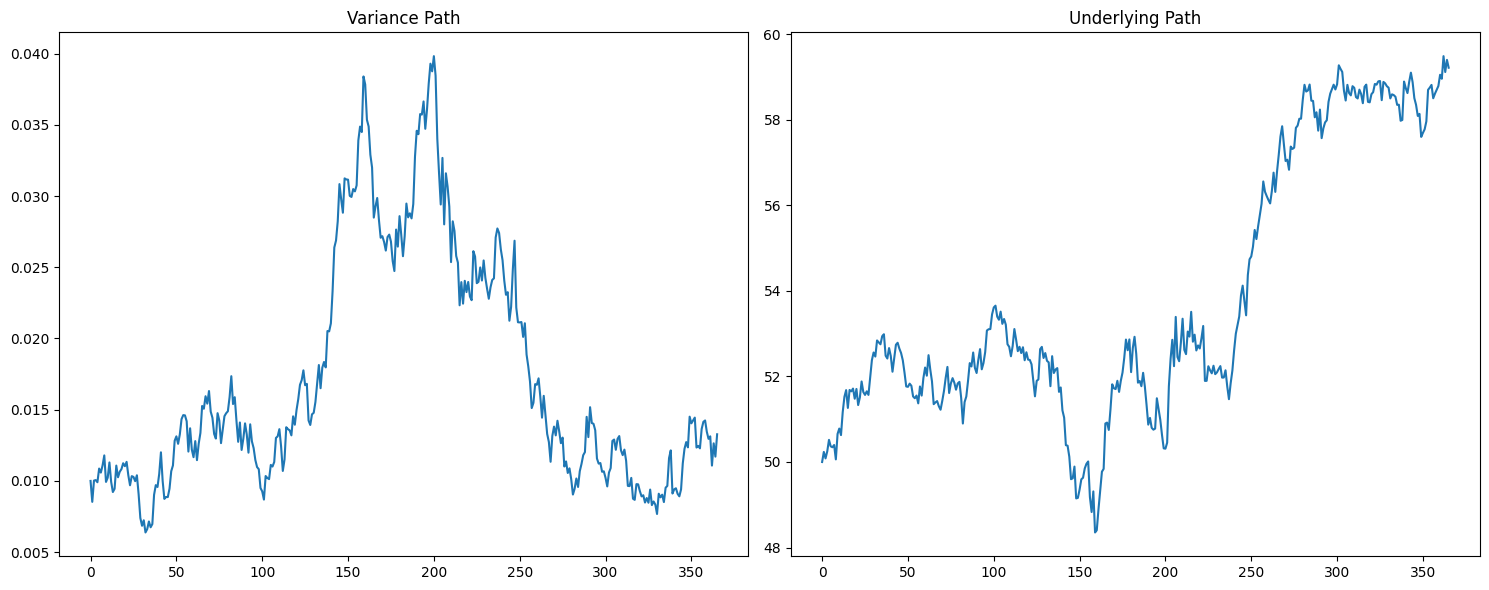

In [24]:
k = 0.5
gamma = 0.2
vbar = 0.05
alpha_star = 1.5
v0 = 0.01
S0 = 50
rho = -0.9
r = 0.1
ndays = 365
nsim = 10000
np.random.seed(42)
HestClass = Cir(gamma, k , vbar, v0, S0, rho, r, 365, nsim)
HestClass.simulation_heston()

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(HestClass.serie[0,:])
ax[0].set_title("Variance Path")
ax[1].plot(HestClass.serie_heston[0,:])
ax[1].set_title("Underlying Path")
plt.show()


### Distribution
- `Cos_method_density()` + `plot_distribution()`  
  Recovers the terminal density of `log(S_T)` via COS expansion and plots it (also transformed to `S_T`).


∫ f_log(x) dx = 0.904837, ∫ f_S(s) ds = 0.904853


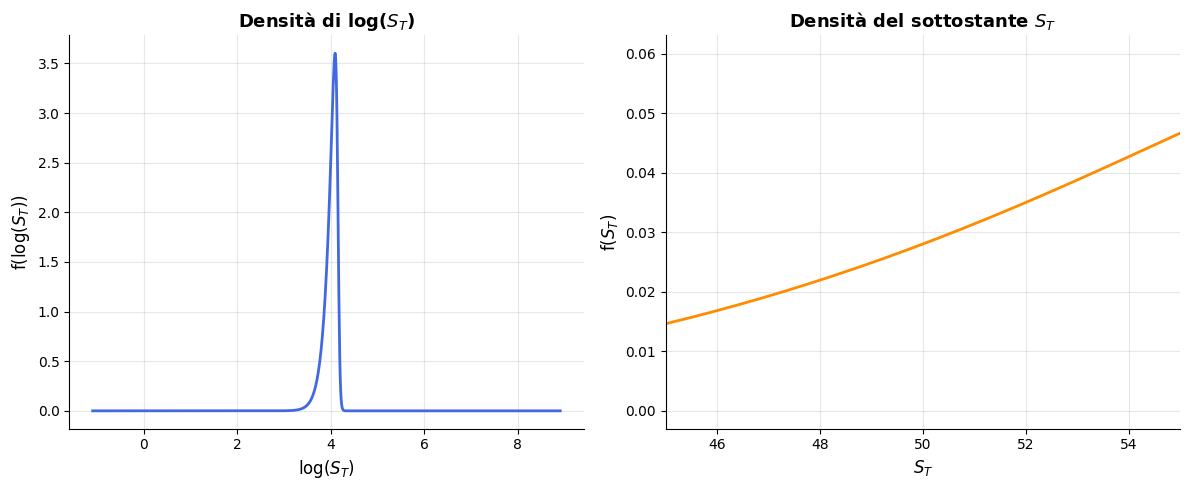

In [25]:
HestClass.plot_distribution()

### Pricing
- `call_eu(K, cos_method=True, use_control_variable=True)`  
  European call priced either via **COS** (default) or **Monte Carlo**.

- `put_eu(K, cos_method=True, use_control_variable=True)`  
  European put priced either via **COS** (default) or **Monte Carlo**.

- `down_and_out(down_barrier, K, use_control_variable=True)`  
  Down-and-out call via Monte Carlo with barrier monitoring (discrete daily grid).

- `Variance_Swap_FS(use_control_variable=True)`  
  Fair strike of a variance swap computed from realized log-returns.


In [20]:
HestClass.call_eu(K=50, cos_method=False, use_control_variable=True)
print("------------------------------------------------------------")
HestClass.call_eu(K=50, cos_method=True,)
print("------------------------------------------------------------")
HestClass.put_eu(K=50, cos_method=False, use_control_variable=True)
print("------------------------------------------------------------")
HestClass.put_eu(K=50, cos_method=True,)
print("------------------------------------------------------------")
HestClass.Variance_Swap_FS(use_control_variable=True)
print("------------------------------------------------------------")

Varianza payoff: 20.03598887472069
Il Prezzo di un'Opzione Call EU che scade tra 365 giorni con strike: 50  è di 5.790624404822222
Varianza Control: 2.44828530609595
Tempo Impiegato in Secondi: 0
------------------------------------------------------------
Prezzo Opzione Call EU con Cos Method:5.826369626949256
------------------------------------------------------------
Varianza payoff: 8.781794743652084
Il Prezzo di un'Opzione Put EU che scade tra 365 giorni con strike: 50  è di 1.0850101335589066
Varianza Control: 1.1219267486505566
Tempo Impiegato in Secondi: 0
------------------------------------------------------------
Prezzo Opzione Put EU con Cos Method: 1.0682405287420529
------------------------------------------------------------
Varianza payoff: 0.00014503342309688913
Il Fair Strike Price di un Variance Swap che Scade tra 365 Giorni è K: 0.018575850967321863
Varianza Control: 5.8431992120597384e-05
Tempo Impiegato in Secondi: 0
----------------------------------------------

### Greeks
- `call_eu_delta_gamma(K)`, `put_eu_delta_gamma(K)`  
  Delta and Gamma via derivatives of the COS representation.

- `call_eu_vega(K)`, `put_eu_vega(K)`  
  Vega via differentiation of the characteristic function.

In [26]:
delta, gamma = HestClass.call_eu_delta_gamma(50)
vega = HestClass.call_eu_vega(50)
print(f"Call EU delta:{delta}, gamma: {gamma}, vega: {vega}")
delta, gamma = HestClass.put_eu_delta_gamma(50)
vega = HestClass.put_eu_vega(50)
print(f"Put EU delta:{delta}, gamma: {gamma}, vega: {vega}")


Call EU delta:0.7539249996373931, gamma: 0.02535246372667028, vega: 40.579481391889026
Put EU delta:-0.15090172096102422, gamma: 0.02535030303177996, vega: 40.569000417215804
